<a href="https://colab.research.google.com/github/Lykozy/Transfer-Learning-Metal/blob/main/TfLn_Result_Metal_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load_model digunakan untuk meload model sebelumnya yang sudah ditraining (result_metal_2.h5) pada notebook TfLn_Result_Metal_2.ipynb
# yang nantinya akan dilatih lagi dengan data yang dan akan digunakan untuk memprediksi harga metal seperti yang dilakukan pada notebook 
# TfLn_Result_Metal_2.ipynb

from keras.models import load_model
model = load_model('/content/drive/MyDrive/TransferLearning/Model_2/result_metal_2.h5')

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 120, 128)          34816     
                                                                 
 sequential_2 (Sequential)   (None, 120, 64)           41472     
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

# Transfer Learning

Pada notebook ini Transfer Learning akan diterapkan pada model baru menggunakan model 1 yaitu result_metal_1 yang outputnya akan menghasilkan model 2 bernama result_metal_2. Model 2 akan dilatih hanya dengan data Aluminum atau Aluminium, kolom yang akan digunakan adalah X = open dan volume, Y = close.

## Instal yang diperlukan

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from math import sqrt

In [ ]:
df = pandas.read_csv('/content/drive/MyDrive/transfer_learning_metal_dataset/Data Historis Aluminium Berjang.csv')

## EDA

In [ ]:
df

,date,close,open,high,low,volume
0,2019-10-1,1.740,1.719,1.740,1.719,473950
1,2019-10-2,1.705,1.723,1.722,1.706,484720
2,2019-10-3,1.718,1.712,1.718,1.710,329770
3,2019-10-4,1.719,1.717,1.719,1.715,286900
4,2019-10-7,1.746,1.722,1.746,1.720,347490
...,...,...,...,...,...,...
503,2021-9-27,2.884,2.904,2.903,2.904,42200
504,2021-9-28,2.945,2.916,2.917,2.916,59190
505,2021-9-29,2.912,2.937,2.935,2.930,36670
506,2021-9-30,2.859,2.870,2.866,2.867,60390


In [ ]:
print('Number of missing values : ' + str(df.isna().sum().sum()))
print(df.shape)

Number of missing values : 0
(508, 6)


In [ ]:
df = df.drop(['date'], axis = 1)

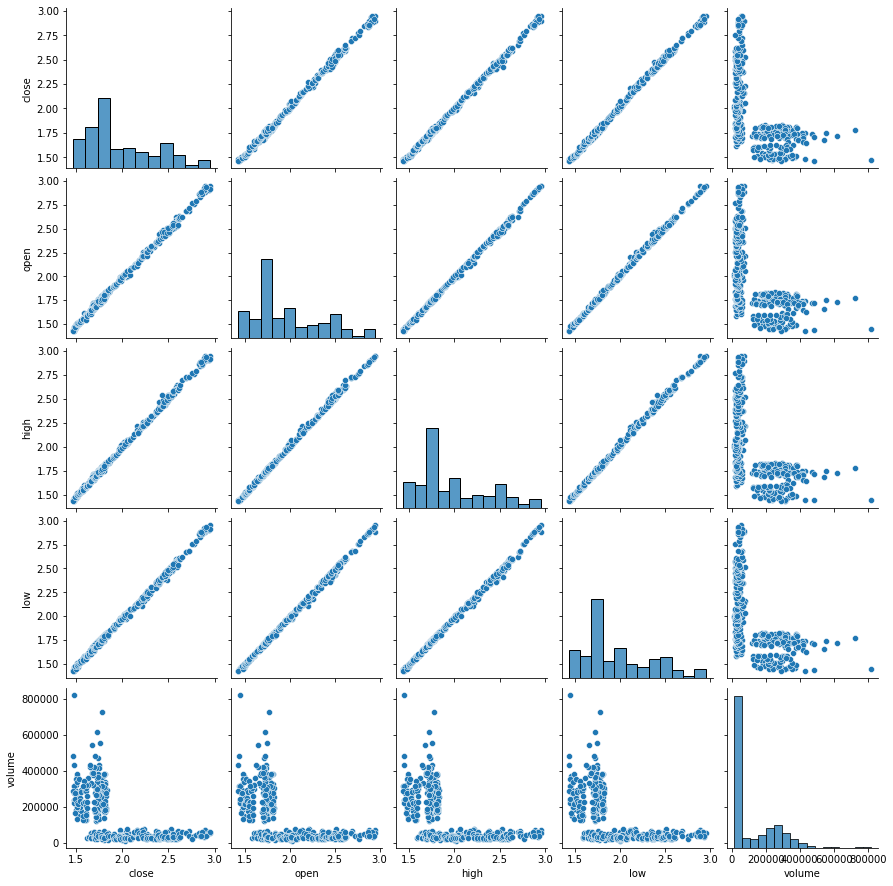

In [ ]:
sb.pairplot(df)

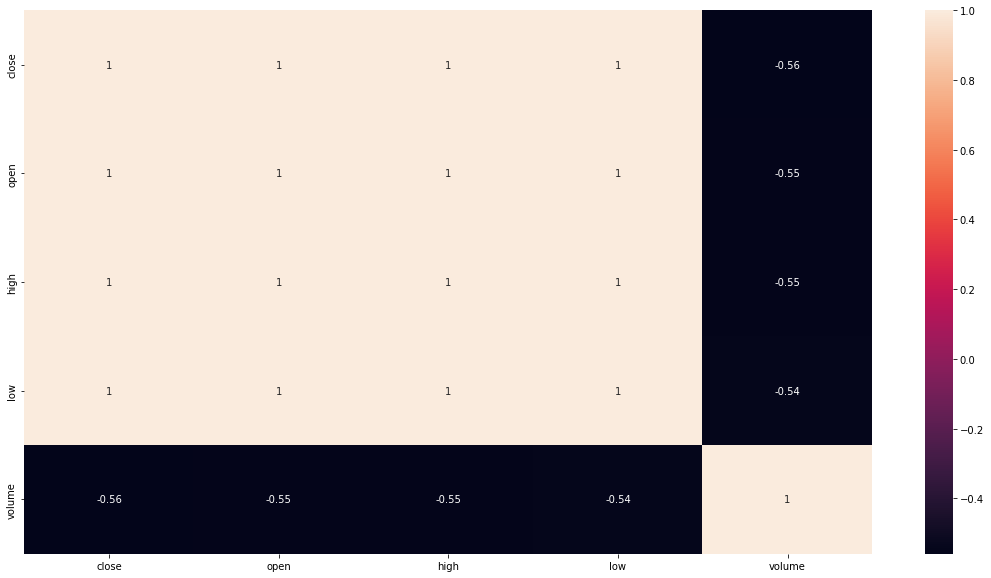

In [ ]:
cor_mat = df.corr ()
fig = plt.figure(figsize = (19,10))
sb.heatmap(cor_mat, annot = True)
plt.show ()

In [ ]:
print (cor_mat['close'].sort_values(ascending = False), '\n')

close     1.000000
high      0.999107
open      0.998909
low       0.998742
volume   -0.558712
Name: close, dtype: float64 



In [ ]:
column_position = ['open', 'close', 'low', 'high', 'volume']

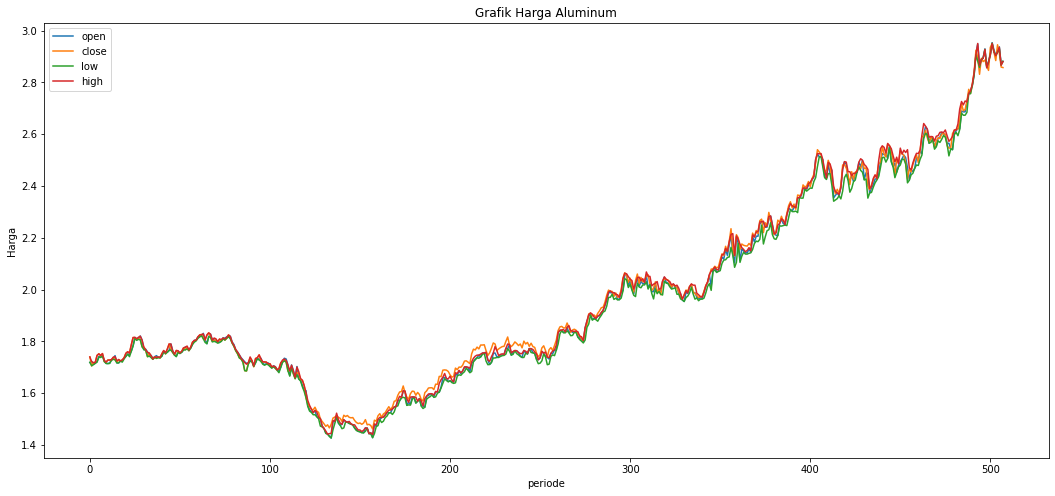

In [ ]:
plt.figure(figsize = (18, 8))
plt.plot(df['open'])
plt.plot(df['close'])
plt.plot(df['low'])
plt.plot(df['high'])
plt.legend(['open', 'close','low','high'])
plt.xlabel('periode')
plt.ylabel('Harga')
plt.title('Grafik Harga Aluminum')
plt.savefig('/content/drive/MyDrive/TransferLearning/Model_3/metal_3_Aluminum.png')
plt.show()

* Berhubung open, close, low, high memiliki nilai yang hampir sama, maka hanya 1 yang akan digunakan untuk memberi makan model yaitu close. *

In [ ]:
info = [[col, df[col].count(), df[col].max(), df[col].min()] for col in df.columns]
print(tabulate(info, headers = ['Feature', 'Count', 'Maximum', 'Minimum'], tablefmt= 'orgtbl'))

| Feature   |   Count |    Maximum |   Minimum |
|-----------+---------+------------+-----------|
| close     |     508 |      2.95  |     1.462 |
| open      |     508 |      2.953 |     1.427 |
| high      |     508 |      2.95  |     1.441 |
| low       |     508 |      2.951 |     1.427 |
| volume    |     508 | 819110     | 13620     |


## Membuat dataset array

In [ ]:
X = np.array(df.drop(['high', 'low', 'close'], axis = 1))
y = np.array(df['close'])

In [ ]:
print(X.shape)
print(y.shape)

(508, 2)
(508,)


## Menskalakan data dengan MinMaxScaler

In [ ]:
X = MinMaxScaler().fit_transform(X)

In [ ]:
t = np.reshape(y, (len(y),1))
t = MinMaxScaler().fit_transform(t)
y = t.reshape(-1)

In [ ]:
print(X.max())
print(X.min())

1.0
0.0


In [ ]:
print(y.max())
print(y.min())

1.0
0.0


## Membuat array numpy berbasis deret waktu

In [ ]:
length = 120

X_res = []
y_res = []

for i in range(length , len(X)) :
    X_res.append(X[i-length:i])
    y_res.append(y[i])

X_res = np.array(X_res)
y_res = np.array(y_res)

In [ ]:
print(X_res.shape)
print(y_res.shape)

(388, 120, 2)
(388,)


## Prediksi Aluminum

In [ ]:
for i, layer in enumerate(model.layers) :
    if i < 5 :
        layer.trainable = True # Layer akan dilatih lagi

## Train test split

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X_res, y_res, train_size = 0.8, test_size = 0.2, random_state = 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(310, 120, 2)
(310,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(78, 120, 2)
(78,)


## Training Model

In [ ]:
checkp = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/TransferLearning/Model_3/result_metal_3.h5', save_best_only = False, verbose = 1), 
          tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/TransferLearning/Model_3/result_metal_3.log', separator=",", append=False)]

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    epochs = 200, 
    batch_size = 64, 
    validation_data = (X_test, y_test), 
    callbacks = [checkp])

Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.0065
Epoch 1: saving model to /content/drive/MyDrive/TransferLearning/Model_3/result_metal_3.h5
5/5 [==============================] - 12s 1s/step - loss: 0.0138 - accuracy: 0.0065 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.0065
Epoch 2: saving model to /content/drive/MyDrive/TransferLearning/Model_3/result_metal_3.h5
5/5 [==============================] - 2s 449ms/step - loss: 0.0116 - accuracy: 0.0065 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.0065
Epoch 3: saving model to /content/drive/MyDrive/TransferLearning/Model_3/result_metal_3.h5
5/5 [==============================] - 2s 445ms/step - loss: 0.0081 - accuracy: 0.0065 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 4/200
5/5 [==============================] - 

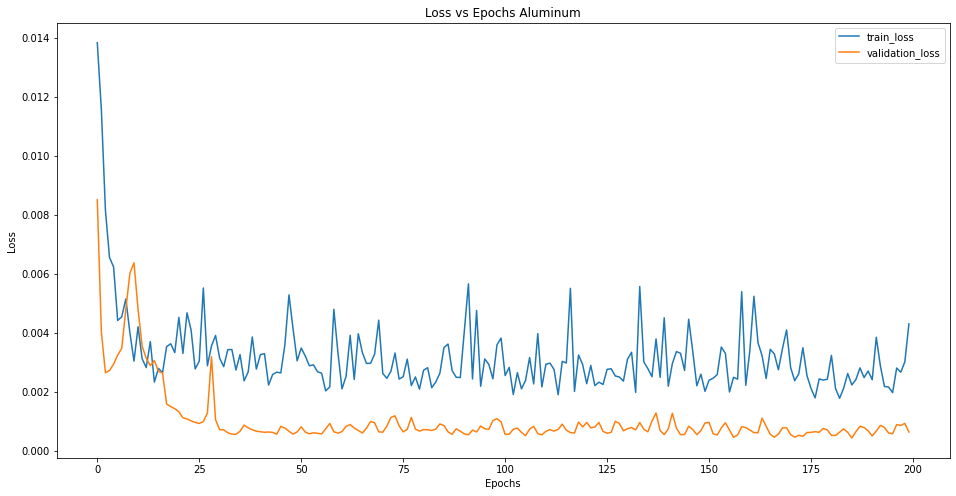

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs Aluminum')
plt.savefig('/content/drive/MyDrive/TransferLearning/Model_3/result_metal_3_loss.png')
plt.show()

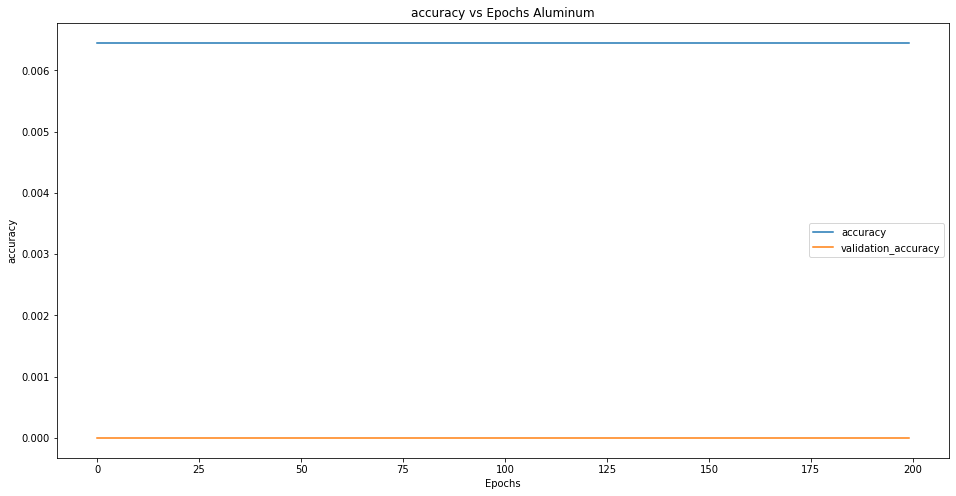

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'validation_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs Epochs Aluminum')
plt.savefig('/content/drive/MyDrive/TransferLearning/Model_3/result_metal_3_acc.png')
plt.show()

## Prediksi

In [ ]:
model = load_model('/content/drive/MyDrive/TransferLearning/Model_3/result_metal_3.h5')
pred = model.predict(X_test)

In [ ]:
print(pred.shape)

(78, 1)


## Plot the Prediction and Test value

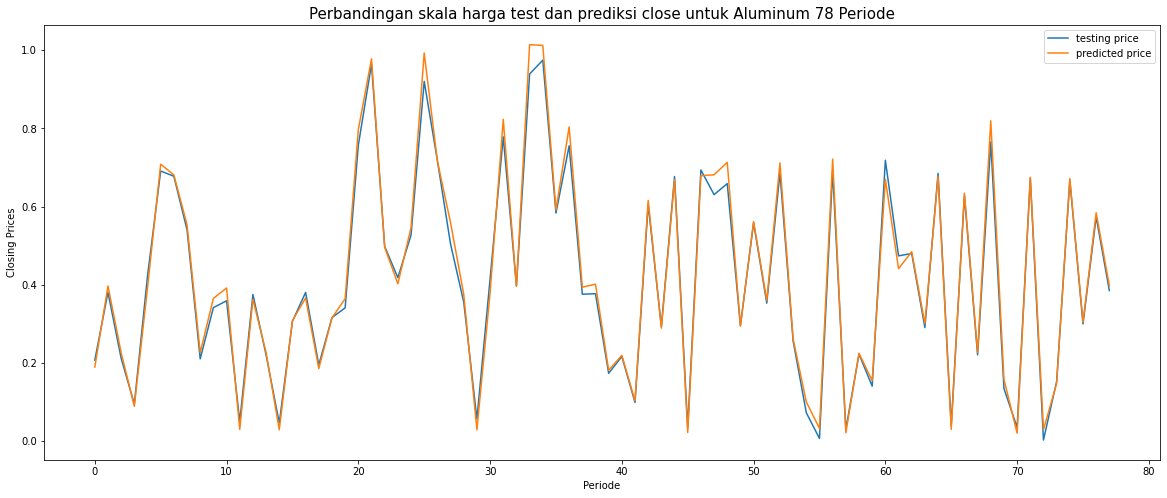

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(y_test)
plt.plot(pred)
plt.xlabel('Periode')
plt.ylabel('Closing Prices')
plt.legend(['testing price','predicted price'])
plt.title('Perbandingan skala harga test dan prediksi close untuk Aluminum 78 Periode', fontsize = 15)
plt.savefig('/content/drive/MyDrive/TransferLearning/Model_3/result_metal_3_comparison_testingVSpredic_78_periode.png')

## Performance Metrics

In [ ]:
print('r2 score : ' + str(r2_score(y_test, pred)))
print('Mean Squared Error (MSE) : ' + str(mean_squared_error(y_test, pred)))
print('Root Mean Squared Error (RMSE) : ' + str(mean_squared_error(y_test, pred, squared=False)))
print('Mean Absolut Error (MAE) : ' + str(mean_absolute_error(y_test, pred)))
print('Mean Absolut Percentage Error (MAPE) : ' + str(mean_absolute_percentage_error(y_test, pred)))

r2 score : 0.990407642718276
Mean Squared Error (MSE) : 0.0006328616626958758
Root Mean Squared Error (RMSE) : 0.025156741893493994
Mean Absolut Error (MAE) : 0.01871867704472001
Mean Absolut Percentage Error (MAPE) : 0.2495394602783613
